<a href="https://colab.research.google.com/github/dylanbforde/Cardiac-MRI-Segmentation/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Augmented_data_loaders

In [29]:
!pip install torchio
!pip install torchinfo
!pip install tensorboard
!pip install monai
!pip install timm

In [30]:
from pathlib import Path
from torch.utils.data import DataLoader
import torchio as tio
import numpy as np
import torch


In [31]:
def get_subjects(image_dir, label_dir):
    image_paths = sorted(image_dir.glob('*.nii.gz'))
    label_paths = sorted(label_dir.glob('*.nii.gz'))
    assert len(image_paths) == len(label_paths)

    subjects = []
    for img_path, lbl_path in zip(image_paths, label_paths):
        subject = tio.Subject(
            mri=tio.ScalarImage(img_path),
            heart=tio.LabelMap(lbl_path)
        )
        subjects.append(subject)
    return subjects

In [32]:
def get_loaders(modality='SA', base_path='/content/drive/Shareddrives/Segmentation Data Split/processed_data', batch_size=4, num_workers=4,
                patch_size=(256, 256, 1), augment=True):

    assert modality in ['SA', 'LA'], "Modality must be 'SA' or 'LA'"

    base_path = Path(base_path)
    paths = {
        'train': {
            'images': base_path / 'train' / modality / 'images',
            'labels': base_path / 'train' / modality / 'labels',
        },
        'val': {
            'images': base_path / 'val' / modality / 'images',
            'labels': base_path / 'val' / modality / 'labels',
        },
        'test': {
            'images': base_path / 'test' / modality / 'images',
            'labels': base_path / 'test' / modality / 'labels',
        }
    }

    # Torchio has some swanky looking transforms - these ones look good can add more?
    # Can find more here: https://docs.torchio.org/transforms/transforms.html
    common_transforms = [
        tio.CropOrPad(patch_size),
        tio.ZNormalization(masking_method=tio.ZNormalization.mean),
        tio.RescaleIntensity(out_min_max=(0, 1)),
    ]

    augment_transforms = [
        tio.RandomFlip(axes=(0, 1), flip_probability=0.5),
        tio.RandomAffine(scales=(0.9, 1.1), degrees=10),
    ] if augment else []

    training_transform = tio.Compose(common_transforms + augment_transforms)
    validation_transform = tio.Compose(common_transforms)


    train_subjects = get_subjects(paths['train']['images'], paths['train']['labels'])
    val_subjects = get_subjects(paths['val']['images'], paths['val']['labels'])
    test_subjects = get_subjects(paths['test']['images'], paths['test']['labels'])

    train_dataset = tio.SubjectsDataset(train_subjects, transform=training_transform)
    val_dataset = tio.SubjectsDataset(val_subjects, transform=validation_transform)
    test_dataset = tio.SubjectsDataset(test_subjects, transform=validation_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    print("Done")

    return train_loader, val_loader, test_loader

In [33]:
train_loader, val_loader, test_loader = get_loaders(
    modality='SA',
    base_path='/content/drive/Shareddrives/Segmentation Data Split/processed_data',
    batch_size=2,
    num_workers=0,
    patch_size=(256, 256,1),
    augment=True
)

Done


Images shape: torch.Size([2, 1, 256, 256, 1])
Labels shape: torch.Size([2, 1, 256, 256, 1])
Subject keys: dict_keys(['mri', 'heart'])


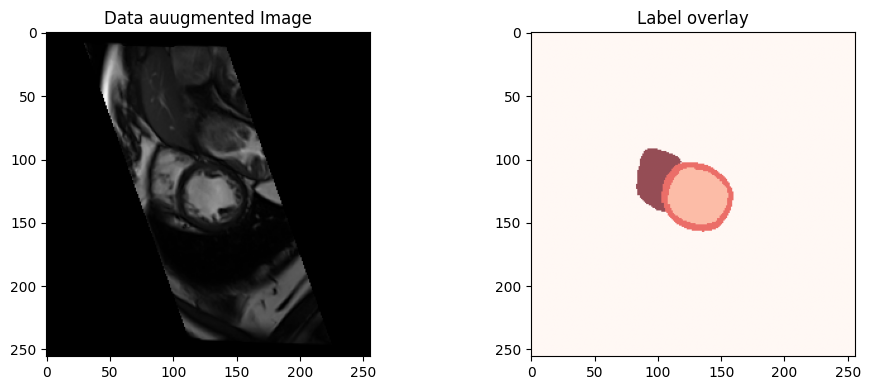

In [34]:
# This just tests it on a single batch to make sure everthing works

import matplotlib.pyplot as plt

batch = next(iter(train_loader))
images = batch['mri'][tio.DATA]
labels = batch['heart'][tio.DATA]

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Subject keys: {batch.keys()}")

img_slice = images[0, 0, :, :, 0].numpy()
lbl_slice = labels[0, 0, :, :, 0].numpy()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_slice, cmap='gray')
plt.title("Data auugmented Image")

plt.subplot(1, 2, 2)
plt.imshow(lbl_slice, cmap='Reds', alpha=0.7)
plt.title("Label overlay")

plt.tight_layout()
plt.show()

## Model

In [35]:
###################################
#      3D SegFormer Model
###################################

import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.layers import DropPath

# 1. Overlapping Patch Embedding (3D)
class OverlapPatchEmbed3D(nn.Module):
    """
    Splits the input 3D volume into overlapping patches via a Conv3d layer
    and projects them into a token embedding space, followed by LayerNorm.
    """
    def __init__(self, img_size, patch_size, stride, in_chans, embed_dim):
        super().__init__()
        # img_size: (D, H, W), patch_size: (pD, pH, pW), stride: (sD, sH, sW)
        padding = tuple(p // 2 for p in patch_size)
        # 3D convolution to extract patch embeddings
        self.proj = nn.Conv3d(in_chans, embed_dim,
                              kernel_size=patch_size,
                              stride=stride,
                              padding=padding)
        # Layer normalization on the channel dimension
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape [B, C, D, H, W]
        Returns:
            tokens: Tensor of shape [B, N, embed_dim], where N = D'*H'*W'
            spatial_dims: Tuple (D', H', W') after projection
        """
        x = self.proj(x)  # [B, embed_dim, D', H', W']
        B, C, D, H, W = x.shape
        # flatten spatial dims, to [B, N, C]
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x, (D, H, W)

# 2. Transformer Encoder Block
class TransformerBlock(nn.Module):
    """
    A single Transformer block: LayerNorm -> MHSA -> residual -> MLP -> residual.
    Supports stochastic depth via DropPath.
    """
    def __init__(self, dim, num_heads, mlp_ratio=4.0,
                 qkv_bias=True, drop=0.0, attn_drop=0.0, drop_path=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads,
                                          dropout=attn_drop,
                                          bias=qkv_bias)
         # DropPath for stochastic depth regularization
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = nn.LayerNorm(dim)
        # MLP with two linear layers and a GELU activation
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(drop)
        )

    def forward(self, x):
        """
        Args:
            x: Tensor of shape [B, N, C]
        Returns:
            Tensor of shape [B, N, C]
        """
        B, N, C = x.size()
        shortcut = x
        x = self.norm1(x)
        x = x.transpose(0, 1) # MHSA expects sequence-first format [N, B, C]
        x, _ = self.attn(x, x, x)
        x = x.transpose(0, 1)
        x = shortcut + self.drop_path(x) # Residual connection + stochastic depth
        x = x + self.drop_path(self.mlp(self.norm2(x))) # MLP with residual and drop path
        return x

# 3. MiT‑backbone for 3D
class MixTransformer3D(nn.Module):
    """
    Hierarchical Vision Transformer backbone adapted for 3D volumes.
    Consists of multiple stages with overlapping patch embeddings and Transformer blocks.
    """
    def __init__(self,
                 img_size=(1, 256, 256),
                 in_chans=1,
                 embed_dims=[64, 128, 320, 512],
                 num_heads=[1, 2, 5, 8],
                 mlp_ratios=[4, 4, 4, 4],
                 depths=[3, 4, 6, 3],
                 drop_path_rate=0.1):
        super().__init__()
        # Compute drop path schedule across all blocks
        total_blocks = sum(depths)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, total_blocks)]
        cur = 0
        self.stages = nn.ModuleList()
        # Build each stage
        for i in range(len(depths)):
            # Spatial dimensions reduce by patch embed stride
            p_dim = img_size if i == 0 else tuple(max(1, dim // (2 ** i)) for dim in img_size)
            patch_size = (3, 3, 3)
            stride = (1, 2, 2)
            # Input channels for this stage
            in_ch = in_chans if i == 0 else embed_dims[i - 1]
            embed_dim = embed_dims[i]

            patch_embed = OverlapPatchEmbed3D(
                img_size=p_dim,
                patch_size=patch_size,
                stride=stride,
                in_chans=in_ch,
                embed_dim=embed_dim
            )
            # Stack Transformer blocks with scheduled drop path
            blocks = nn.ModuleList()
            for j in range(depths[i]):
                blocks.append(
                    TransformerBlock(
                        dim=embed_dim,
                        num_heads=num_heads[i],
                        mlp_ratio=mlp_ratios[i],
                        drop_path=dpr[cur + j]
                    )
                )
            cur += depths[i]
            # Collect stage modules
            self.stages.append(nn.ModuleList([patch_embed, blocks]))

    def forward(self, x):
        """
        Args:
            x: Input volume [B, C, D, H, W]
        Returns:
            features: List of feature maps from each stage, each of shape [B, C_i, D_i, H_i, W_i]
        """
        features = []
        for patch_embed, blocks in self.stages:
            x, (D, H, W) = patch_embed(x) # Apply patch embedding to get tokens
            for blk in blocks: # Process tokens through transformer blocks
                x = blk(x)
            B, N, C = x.size() # Reshape tokens back into 3D feature map
            feat = x.transpose(1, 2).view(B, C, D, H, W)
            features.append(feat)
            # Use output feature map as input to next stage
            x = feat
        return features

# 4. Decoder for 3D semantic segmentation
class SegFormerDecoder3D(nn.Module):
    """
    Simple MLP-style decoder that projects multi-scale features to a common dimension,
    upsamples them, concatenates, and applies a 1×1 classifier.
    """
    def __init__(self, feature_dims=[64, 128, 320, 512], decoder_dim=256, num_classes=21):
        super().__init__()
        # 1×1×1 convolutions to project each feature map to decoder_dim
        self.proj_layers = nn.ModuleList([
            nn.Conv3d(in_ch, decoder_dim, kernel_size=1)
            for in_ch in feature_dims
        ])
        # Classifier: reduce concatenated features and output num_classes channels
        self.classifier = nn.Sequential(
            nn.Conv3d(decoder_dim * len(feature_dims), decoder_dim, kernel_size=1),
            nn.BatchNorm3d(decoder_dim),
            nn.ReLU(),
            nn.Dropout3d(0.1),
            nn.Conv3d(decoder_dim, num_classes, kernel_size=1)
        )

    def forward(self, features):
        """
        Args:
            features: List of feature tensors from backbone
        Returns:
            logits: Segmentation logits at reduced resolution
        """
        # Determine target spatial resolution from the first feature
        target_size = features[0].shape[2:]
        up_feats = []
        # Project and upsample each feature map
        for feat, proj in zip(features, self.proj_layers):
            f = proj(feat)
            if f.shape[2:] != target_size:
                f = F.interpolate(f, size=target_size, mode='trilinear', align_corners=False)
            up_feats.append(f)
        # Concatenate along channel dimension and classify
        x = torch.cat(up_feats, dim=1)
        return self.classifier(x)

# 5. Full 3D SegFormer
class SegFormer3D(nn.Module):
    """
    Complete SegFormer architecture for 3D volumes: backbone + decoder + final upsampling.
    """
    def __init__(self,
                 img_size=(1, 256, 256),
                 in_chans=1,
                 num_classes=21,
                 decoder_dim=256,
                 **backbone_kwargs):
        super().__init__()
        # Backbone: hierarchical transformer feature extractor
        self.backbone = MixTransformer3D(
            img_size=img_size,
            in_chans=in_chans,
            **backbone_kwargs
        )
        # Decoder: projecting and classifying multi-scale features
        self.decoder = SegFormerDecoder3D(
            feature_dims=backbone_kwargs.get('embed_dims', [64,128,320,512]),
            decoder_dim=decoder_dim,
            num_classes=num_classes
        )

    def forward(self, x):
        """
        Args:
            x: Input tensor [B, C, D, H, W]
        Returns:
            seg_logits: Upsampled segmentation logits [B, num_classes, D, H, W]
        """
        features = self.backbone(x)
        seg = self.decoder(features)
        # Upsample to original resolution
        return F.interpolate(seg, size=x.shape[2:], mode='trilinear', align_corners=False)

In [41]:
# Smaller model configuration
model_config_small = {
    'embed_dims': [32, 64, 160, 256],
    'depths': [2, 2, 2, 2],
    'num_heads': [1, 2, 5, 8],
    'mlp_ratios': [4, 4, 4, 4],
}
model = SegFormer3D(
    img_size=(256, 256, 1),
    in_chans=1,
    num_classes=1,
    decoder_dim=128,
    **model_config_small
)
model

SegFormer3D(
  (backbone): MixTransformer3D(
    (stages): ModuleList(
      (0): ModuleList(
        (0): OverlapPatchEmbed3D(
          (proj): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): ModuleList(
          (0): TransformerBlock(
            (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (0): Linear(in_features=32, out_features=128, bias=True)
              (1): GELU(approximate='none')
              (2): Linear(in_features=128, out_features=32, bias=True)
              (3): Dropout(p=0.0, inplace=False)
            )
          )
         

In [42]:
from torch.nn.functional import softmax
# ================================
#  Minimal Smoke Test for SegFormer3D
# ================================
# This snippet performs a quick validation of the 3D SegFormer model,
# ensuring that it produces outputs with the correct shape and that
# the predicted class probabilities are properly normalized.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()
# Generate a synthetic 5D tensor representing a single 3D volume
# Tensor shape: [batch_size, channels, depth, height, width]
# Here: batch_size=1, channels=1 (grayscale), depth=1, height=256, width=256
with torch.no_grad():
    x = torch.randn(1, 1, 1, 256, 256, device=device)
    logits = model(x)

# Verify that the output tensor has the expected dimensions:
#    [batch_size, num_classes, depth, height, width]
# For example, if num_classes=3, we expect: [1, 3, 1, 256, 256]
print("Output shape:", logits.shape)

# Apply softmax along the class dimension to obtain probability maps
#    and confirm that probabilities sum to 1 at each voxel.
probs = softmax(logits, dim=1)       # [1, C, D, H, W]
s = probs.sum(dim=1)                 # [1, D, H, W]
print("Sum per voxel min/max:", s.min().item(), s.max().item())

Output shape: torch.Size([1, 1, 1, 256, 256])
Sum per voxel min/max: 1.0 1.0


In [43]:
# Model architecture visualisation
from torchinfo import summary
summary(
    model,
    input_size=(1,1,1,256,256),
    depth=4,
    col_names=('output_size','num_params'))

Layer (type:depth-idx)                                  Output Shape              Param #
SegFormer3D                                             [1, 1, 1, 256, 256]       --
├─MixTransformer3D: 1-1                                 [1, 32, 1, 128, 128]      --
│    └─ModuleList: 2-1                                  --                        --
│    │    └─ModuleList: 3-1                             --                        --
│    │    │    └─OverlapPatchEmbed3D: 4-1               [1, 16384, 32]            960
│    │    │    └─ModuleList: 4-2                        --                        25,408
│    │    └─ModuleList: 3-2                             --                        --
│    │    │    └─OverlapPatchEmbed3D: 4-3               [1, 4096, 64]             55,488
│    │    │    └─ModuleList: 4-4                        --                        99,968
│    │    └─ModuleList: 3-3                             --                        --
│    │    │    └─OverlapPatchEmbed3D: 4-5      

## Model Training

In [44]:
from monai.metrics import HausdorffDistanceMetric
import torch.optim as optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import os
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="torchio.data.image")


def dice_coefficient(pred, target, smooth=1e-5):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2,3,4))
    union = pred.sum(dim=(2,3,4)) + target.sum(dim=(2,3,4))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2.0, weight=None, size_average=True):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_loss = nn.BCEWithLogitsLoss(weight=weight, size_average=size_average)

    def forward(self, inputs, targets, smooth=1):
        # Dice Loss
        dice_loss = 1 - dice_coefficient(inputs, targets, smooth)

        # Focal Loss
        bce = self.bce_loss(inputs, targets)
        bce_exp = torch.exp(-bce)
        focal_loss = self.alpha * (1-bce_exp)**self.gamma * bce

        return 2 * dice_loss + focal_loss

def save_model(model, path):
    """Saves the model state dictionary to a file."""
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def train_model(model, train_loader, val_loader, num_epochs=25, learning_rate=1e-4, save_path=None, accumulation_steps=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = CombinedLoss()
    writer = SummaryWriter()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        optimizer.zero_grad()
        for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")):
            images = batch['mri'][tio.DATA].to(device)
            labels = batch['heart'][tio.DATA].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss = loss / accumulation_steps
            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            train_loss += loss.item() * accumulation_steps

        train_loss /= len(train_loader)
        writer.add_scalar('Loss/train', train_loss, epoch)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                images = batch['mri'][tio.DATA].to(device)
                labels = batch['heart'][tio.DATA].to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

        val_loss /= len(val_loader)
        writer.add_scalar('Loss/val', val_loss, epoch)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    writer.close()
    if save_path:
        save_model(model, save_path)
    print("Training finished.")

In [ ]:
# Get SA and LA data loaders
sa_train_loader, sa_val_loader, sa_test_loader = get_loaders(modality='SA', batch_size=1)
la_train_loader, la_val_loader, la_test_loader = get_loaders(modality='LA', batch_size=1)

# Smaller model configuration
model_config_small = {
    'embed_dims': [32, 64, 160, 256],
    'depths': [2, 2, 2, 2],
    'num_heads': [1, 2, 5, 8],
    'mlp_ratios': [4, 4, 4, 4],
}

# Train the SA model
print("Training SA model...")
sa_model = SegFormer3D(
    img_size=(256, 256, 1),
    in_chans=1,
    num_classes=1,
    decoder_dim=128,
    **model_config_small
)
sa_model_save_path = '/content/drive/Shareddrives/Segmentation Data Split/segformer_model_sa_small.pth'
train_model(
    sa_model,
    sa_train_loader,
    sa_val_loader,
    num_epochs=5,
    learning_rate=1e-4,
    save_path=sa_model_save_path,
    accumulation_steps=4
)

# Train the LA model
print("Training LA model...")
la_model = SegFormer3D(
    img_size=(256, 256, 1),
    in_chans=1,
    num_classes=1,
    decoder_dim=128,
    **model_config_small
)
la_model_save_path = '/content/drive/Shareddrives/Segmentation Data Split/segformer_model_la_small.pth'
train_model(
    la_model,
    la_train_loader,
    la_val_loader,
    num_epochs=5,
    learning_rate=1e-4,
    save_path=la_model_save_path,
    accumulation_steps=4
)

Done
Done
Training SA model...


Epoch 1/5 [Val]: 100%|██████████| 3275/3275 [24:11<00:00,  2.26it/s]


Epoch 1/5, Train Loss: 1.5256, Val Loss: 1.6155


Epoch 2/5 [Val]: 100%|██████████| 3275/3275 [06:56<00:00,  7.87it/s]


Epoch 2/5, Train Loss: 1.4604, Val Loss: 1.3954


Epoch 3/5 [Val]: 100%|██████████| 3275/3275 [06:56<00:00,  7.87it/s]


Epoch 3/5, Train Loss: 1.4197, Val Loss: 1.5761


Epoch 4/5 [Val]: 100%|██████████| 3275/3275 [06:56<00:00,  7.87it/s]


Epoch 4/5, Train Loss: 1.3933, Val Loss: 1.4632


Epoch 5/5 [Val]: 100%|██████████| 3275/3275 [06:56<00:00,  7.86it/s]


Epoch 5/5, Train Loss: 1.4006, Val Loss: 1.4086
Model saved to /content/drive/Shareddrives/Segmentation Data Split/segformer_model_sa_small.pth
Training finished.
Training LA model...


Epoch 1/5 [Train]:  78%|███████▊  | 224/288 [01:46<00:29,  2.14it/s]

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_predictions(model, loader, num_samples=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(loader):
            if i >= num_samples:
                break

            images = batch['mri'][tio.DATA].to(device)
            labels = batch['heart'][tio.DATA].to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5

            img_slice = images[0, 0, :, :, 0].cpu().numpy()
            lbl_slice = labels[0, 0, :, :, 0].cpu().numpy()
            pred_slice = preds[0, 0, :, :, 0].cpu().numpy()

            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(img_slice, cmap='gray')
            plt.title('Input Image')

            plt.subplot(1, 3, 2)
            plt.imshow(lbl_slice, cmap='Reds', alpha=0.7)
            plt.title('Ground Truth')

            plt.subplot(1, 3, 3)
            plt.imshow(pred_slice, cmap='Blues', alpha=0.7)
            plt.title('Predicted Mask')

            plt.tight_layout()
            plt.show()

visualize_predictions(model, test_loader)